# Appended regression with to the notebook "ML_models_institute_with_field_&_location_filter.ipynb"

# This notebook trains the models with adding extra features from the course-level processed data - course_level_processed_combined.csv

Integrating course-level (program data) to our previous model ("ML_models_insttitte_level_only.ipynb") seems like a good idea but mainly because:


Two universities might look the same at institution-level (ENG_RATIO, cost, retention), but one has more engineering programs or lower typical debt in those programs. Course-level file already contains that (DEBT_* fields by CIP, etc.). That’s extra signal current model doesn’t see.

Our initial idea - explicitly talks about “Which stream at this college is the best fit?” and program-level outcomes (debt, earnings). 

Even if the ROC AUC only improves a bit, being able to say “this college has 8 engineering majors with relatively low debt” is a big win for the product.

For pure VALUE_LABEL prediction (affordable + good quality), course-level aggregates might give a modest metric bump, because QUALITY_SCORE and COSTT4_A already encode a lot. But they’re definitely useful as extra features and for the final ranking and explanation layer.

Incorporating location filter in the same notebook - (location_filter.ipynb)
This is done caring less about improving ROC AUC and more about:
Hard constraints (“I only want colleges within 200 km of home”).
A weighted objective (“location = 4/5 importance”).

How course level + location filter gets incorpoprated in the notebook - high level understanding :



Augment institution-level X with course aggregates
From course_level_processed_combined.csv (already engineering-only), build per-UNITID features like:

ENG_PROG_COUNT = number of distinct engineering programs (CIPCODE nunique).

ENG_CRED_LEVELS = number of different credential levels (bachelor, master, etc.).

DEBT_ALL_STGP_ANY_MDN_mean/min/max = typical program-level debt stats for engineering.
Then merge onto the inst_df and include them as features in the VALUE_LABEL classifier.

Keep VALUE_LABEL definition as institution-level
Still define something like “affordable + high quality” from COSTT4_A and QUALITY_SCORE and possibly outcomes = target y. Don’t mix course-level into the label to avoid weird leakage.

Use location at serving time
Implement:

annotate_distance(df, user_lat, user_lon) → add DISTANCE_KM.

filter_by_radius(df, user_lat, user_lon, radius_km) → only nearby schools.
Then let the user give a location weight (0–5) and use DISTANCE_KM in the final USER_SCORE.

Multi-model comparison view
For each model (Logistic, RF, GB, KNN), after GridSearchCV:

Store cv_results_ into a DataFrame.

Plot a bar chart of mean CV ROC AUC for the top N hyperparameter combos.

Also plot a bar chart of test ROC AUC per model.


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [4]:
# -------------------------------------------------------------------
# 1. Paths & basic config
# -------------------------------------------------------------------

INSTITUTION_CSV = "institute_level_processed_most_recent.csv"   # <-- change if needed
COURSE_CSV      = "course_level_processed_combined.csv"          # <-- change if needed

# -------------------------------------------------------------------
# 2. Load & merge institution-level and course-level features
# -------------------------------------------------------------------

inst_df = pd.read_csv(INSTITUTION_CSV)
course_df = pd.read_csv(COURSE_CSV, low_memory=False)

print("Institution-level shape:", inst_df.shape)
print("Course-level shape:", course_df.shape)


Institution-level shape: (5650, 33)
Course-level shape: (121798, 71)


In [5]:
# ---- Make UNITID a consistent integer key ----

# Institution data
inst_df["UNITID"] = pd.to_numeric(inst_df["UNITID"], errors="coerce")
inst_df = inst_df.dropna(subset=["UNITID"])
inst_df["UNITID"] = inst_df["UNITID"].astype(int)

# Course-level data
course_df["UNITID"] = pd.to_numeric(course_df["UNITID"], errors="coerce")
before = len(course_df)
course_df = course_df.dropna(subset=["UNITID"])
after = len(course_df)
print(f"Dropped {before - after} invalid UNITID rows from course_df.")
course_df["UNITID"] = course_df["UNITID"].astype(int)

Dropped 2401 invalid UNITID rows from course_df.


In [6]:
# -------------------------------------------------------------------
# 3. Aggregate course-level features to institution level
# -------------------------------------------------------------------

# Columns we’d like to use for debt stats
agg_cols = [
    "DEBT_ALL_STGP_ANY_MDN",
    "DEBT_ALL_PP_ANY_MDN",
]

# Warn if missing
for col in agg_cols:
    if col not in course_df.columns:
        print(f"Warning: {col} not found in course-level data")


In [7]:
# Coerce debt columns to numeric (strings like 'PrivacySuppressed' -> NaN)
for col in agg_cols:
    if col in course_df.columns:
        course_df[col] = pd.to_numeric(course_df[col], errors="coerce")

# Build subset with only relevant columns
base_cols_for_course = ["UNITID", "CIPCODE", "CREDLEV"]
course_df_subset_cols = base_cols_for_course + [c for c in agg_cols if c in course_df.columns]
course_df_subset = course_df[course_df_subset_cols].copy()


In [8]:
course_df_subset

,UNITID,CIPCODE,CREDLEV,DEBT_ALL_STGP_ANY_MDN,DEBT_ALL_PP_ANY_MDN
0,100654,1408,3,NaN,NaN
1,100654,1410,3,32750.0,NaN
2,100654,1419,3,42117.0,NaN
3,100654,1499,5,NaN,NaN
4,100654,1503,3,NaN,NaN
...,...,...,...,...,...
121391,497000,1513,1,12965.0,NaN
121392,497046,1500,2,NaN,NaN
121393,497046,1506,1,NaN,NaN
121394,497046,1508,1,NaN,NaN


In [9]:
# Aggregation dictionary
agg_dict = {
    "CIPCODE": "nunique",   # number of distinct engineering programs
    "CREDLEV": "nunique",   # number of distinct credential levels
}

In [10]:
if "DEBT_ALL_STGP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_STGP_ANY_MDN"] = ["mean", "min", "max"]
if "DEBT_ALL_PP_ANY_MDN" in course_df_subset.columns:
    agg_dict["DEBT_ALL_PP_ANY_MDN"] = ["mean", "min", "max"]

course_agg = course_df_subset.groupby("UNITID").agg(agg_dict)

In [11]:
course_agg

CIPCODE CREDLEV DEBT_ALL_STGP_ANY_MDN                    \
       nunique nunique                  mean      min      max   
UNITID                                                           
100654       8       2          34450.833333  30500.0  42117.0   
100663      10       4          26107.857143  19000.0  31000.0   
100706       9       5          26011.552632  20799.0  31000.0   
100724       1       1                   NaN      NaN      NaN   
100751      13       3          25551.566667  21500.0  28750.0   
...        ...     ...                   ...      ...      ...   
495970       1       1                   NaN      NaN      NaN   
496186       1       2          21696.000000  21696.0  21696.0   
496645       1       1                   NaN      NaN      NaN   
497000       1       1          12965.000000  12965.0  12965.0   
497046       3       2                   NaN      NaN      NaN   

       DEBT_ALL_PP_ANY_MDN                    
                      mean      min      max  
UNITID                                        
100654        16515.600000  12866.0  17806.0  
100663                 NaN      NaN      NaN  
100706                 NaN      NaN      NaN  
100724                 NaN      NaN      NaN  
100751        33295.888889  24271.0  45453.0  
...                    ...      ...      ...  
495970                 NaN      NaN      NaN  
496186                 NaN      NaN      NaN  
496645                 NaN      NaN      NaN  
497000                 NaN      NaN      NaN  
497046                 NaN      NaN      NaN  

[2875 rows x 8 columns]

In [12]:
# Flatten MultiIndex columns
course_agg.columns = [
    "_".join([str(c) for c in col if c]) if isinstance(col, tuple) else col
    for col in course_agg.columns
]

course_agg = course_agg.rename(columns={
    "CIPCODE_nunique": "ENG_PROG_COUNT",
    "CREDLEV_nunique": "ENG_CRED_LEVELS"
})

print("Aggregated course-level shape:", course_agg.shape)

Aggregated course-level shape: (2875, 8)


In [13]:
course_agg

,ENG_PROG_COUNT,ENG_CRED_LEVELS,DEBT_ALL_STGP_ANY_MDN_mean,DEBT_ALL_STGP_ANY_MDN_min,DEBT_ALL_STGP_ANY_MDN_max,DEBT_ALL_PP_ANY_MDN_mean,DEBT_ALL_PP_ANY_MDN_min,DEBT_ALL_PP_ANY_MDN_max
UNITID,,,,,,,,
100654,8,2,34450.833333,30500.0,42117.0,16515.600000,12866.0,17806.0
100663,10,4,26107.857143,19000.0,31000.0,NaN,NaN,NaN
100706,9,5,26011.552632,20799.0,31000.0,NaN,NaN,NaN
100724,1,1,NaN,NaN,NaN,NaN,NaN,NaN
100751,13,3,25551.566667,21500.0,28750.0,33295.888889,24271.0,45453.0
...,...,...,...,...,...,...,...,...
495970,1,1,NaN,NaN,NaN,NaN,NaN,NaN
496186,1,2,21696.000000,21696.0,21696.0,NaN,NaN,NaN
496645,1,1,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Merge onto institution dataframe
df = inst_df.merge(course_agg, on="UNITID", how="left")
print("Merged df shape:", df.shape)

Merged df shape: (5650, 41)


In [15]:
df

,UNITID,INSTNM,CITY,STABBR,LATITUDE,LONGITUDE,PCIP14,PCIP15,ENG_TOTAL,ENG_RATIO,...,IS_PRIVATE,IS_FORPROFIT,ENG_PROG_COUNT,ENG_CRED_LEVELS,DEBT_ALL_STGP_ANY_MDN_mean,DEBT_ALL_STGP_ANY_MDN_min,DEBT_ALL_STGP_ANY_MDN_max,DEBT_ALL_PP_ANY_MDN_mean,DEBT_ALL_PP_ANY_MDN_min,DEBT_ALL_PP_ANY_MDN_max
0,100654,Alabama A & M University,Normal,AL,34.783368,-86.568502,0.1115,0.0372,0.1487,0.148700,...,0,0,8.0,2.0,34450.833333,30500.0,42117.0,16515.6,12866.0,17806.0
1,100663,University of Alabama at Birmingham,Birmingham,AL,33.505697,-86.799345,0.0581,0.0000,0.0581,0.058100,...,0,0,10.0,4.0,26107.857143,19000.0,31000.0,NaN,NaN,NaN
2,100690,Amridge University,Montgomery,AL,32.362609,-86.174010,0.0000,0.0000,0.0000,0.000000,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100706,University of Alabama in Huntsville,Huntsville,AL,34.724557,-86.640449,0.3086,0.0037,0.3123,0.312269,...,0,0,9.0,5.0,26011.552632,20799.0,31000.0,NaN,NaN,NaN
4,100724,Alabama State University,Montgomery,AL,32.364317,-86.295677,0.0168,0.0000,0.0168,0.016807,...,0,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,499662,Aviation Institute of Maintenance-Phoenix,Phoenix,AZ,33.410174,-112.010360,0.0000,0.0000,0.0000,NaN,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5646,499671,Galen Health Institutes-Las Vegas,Las Vegas,NV,36.071855,-115.294893,0.0000,0.0000,0.0000,NaN,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5647,499680,Stellar Career College-Crown Point,Crown Point,IN,41.474242,-87.401656,0.0000,0.0000,0.0000,0.000000,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5648,499705,Tulsa Welding School-Dallas Campus,Irving,TX,32.836133,-96.937120,0.0000,0.0000,0.0000,NaN,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# -------------------------------------------------------------------
# 4. Define target label (VALUE_LABEL) and feature set
# -------------------------------------------------------------------

# Value label: affordable + good quality (tweakable thresholds)
cost_med = df["COSTT4_A"].median()
quality_med = df["QUALITY_SCORE"].median()
print("Median COSTT4_A:", cost_med)
print("Median QUALITY_SCORE:", quality_med)

Median COSTT4_A: 24517.0
Median QUALITY_SCORE: 0.3101671281203574


In [17]:
df["VALUE_LABEL"] = (
    (df["COSTT4_A"] <= cost_med) &
    (df["QUALITY_SCORE"] >= quality_med)
).astype(int)

print("VALUE_LABEL distribution:")
print(df["VALUE_LABEL"].value_counts(dropna=False))

VALUE_LABEL distribution:
VALUE_LABEL
0    3902
1    1748
Name: count, dtype: int64


In [18]:
# Base institution-level features
base_features = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "MD_EARN_WNE_P10",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]

# New course-level aggregate features
course_features = [
    "ENG_PROG_COUNT", "ENG_CRED_LEVELS",
    "DEBT_ALL_STGP_ANY_MDN_mean",
    "DEBT_ALL_STGP_ANY_MDN_min",
    "DEBT_ALL_STGP_ANY_MDN_max",
    "DEBT_ALL_PP_ANY_MDN_mean",
    "DEBT_ALL_PP_ANY_MDN_min",
    "DEBT_ALL_PP_ANY_MDN_max",
]

Using features: ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'MD_EARN_WNE_P10', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT', 'ENG_PROG_COUNT', 'ENG_CRED_LEVELS', 'DEBT_ALL_STGP_ANY_MDN_mean', 'DEBT_ALL_STGP_ANY_MDN_min', 'DEBT_ALL_STGP_ANY_MDN_max', 'DEBT_ALL_PP_ANY_MDN_mean', 'DEBT_ALL_PP_ANY_MDN_min', 'DEBT_ALL_PP_ANY_MDN_max']
Train size: 4520
Test size: 1130
Running LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for LogisticRegression:
{'clf__C': 1, 'clf__class_weight': 'balanced'}
Best CV ROC AUC: 0.888

Test classification report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       780
           1       0.66      0.88      0.75       350

    accuracy                           0.82      1130
   macro avg       0.80      0.84   

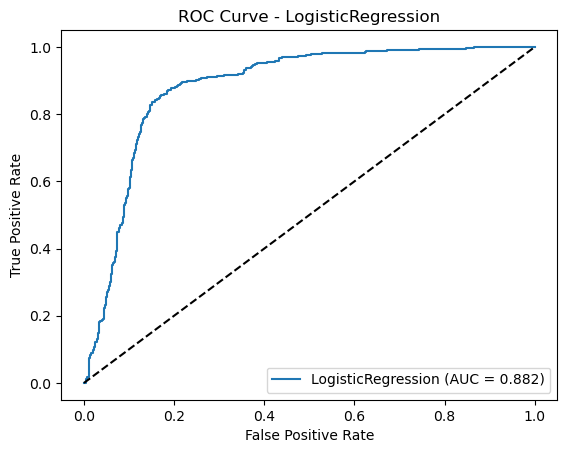

Running RandomForest
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best params for RandomForest:
{'clf__class_weight': 'balanced', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.993

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       780
           1       0.93      0.90      0.91       350

    accuracy                           0.95      1130
   macro avg       0.94      0.93      0.94      1130
weighted avg       0.95      0.95      0.95      1130

Test ROC AUC: 0.9912087912087911
Confusion matrix:
[[756  24]
 [ 35 315]]


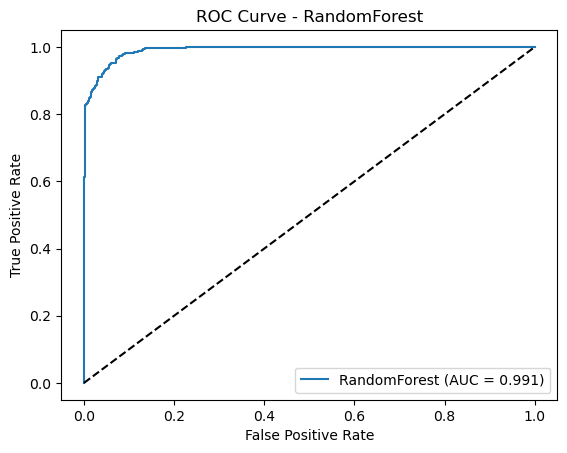

Running GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for GradientBoosting:
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.993

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       780
           1       0.93      0.92      0.93       350

    accuracy                           0.95      1130
   macro avg       0.95      0.94      0.95      1130
weighted avg       0.95      0.95      0.95      1130

Test ROC AUC: 0.9912417582417583
Confusion matrix:
[[756  24]
 [ 28 322]]


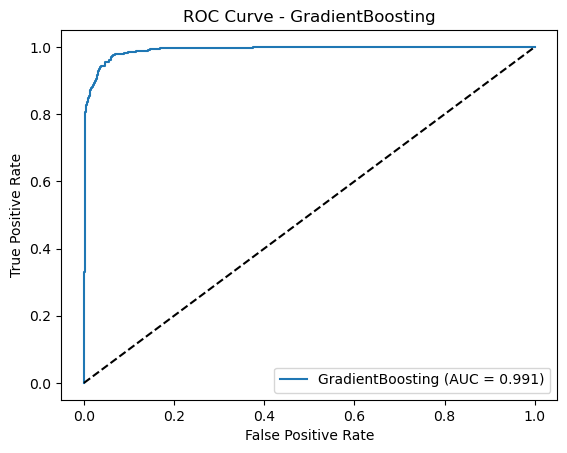

Running KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best params for KNN:
{'clf__n_neighbors': 15, 'clf__weights': 'distance'}
Best CV ROC AUC: 0.931

Test classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       780
           1       0.79      0.73      0.76       350

    accuracy                           0.86      1130
   macro avg       0.84      0.82      0.83      1130
weighted avg       0.85      0.86      0.85      1130

Test ROC AUC: 0.934139194139194
Confusion matrix:
[[714  66]
 [ 96 254]]


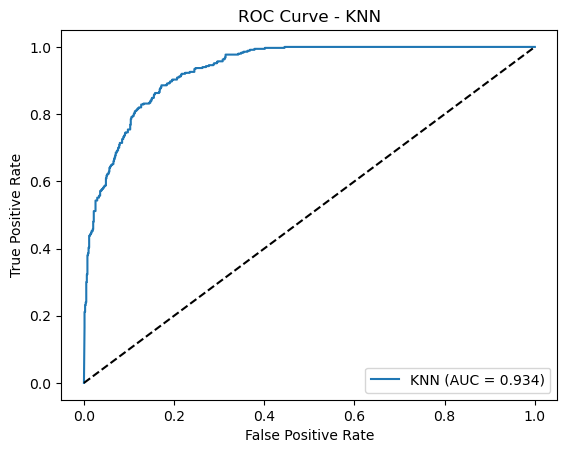

Running SVC
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best params for SVC:
{'clf__C': 10, 'clf__class_weight': None, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV ROC AUC: 0.958

Test classification report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       780
           1       0.84      0.87      0.86       350

    accuracy                           0.91      1130
   macro avg       0.89      0.90      0.89      1130
weighted avg       0.91      0.91      0.91      1130

Test ROC AUC: 0.9626886446886447
Confusion matrix:
[[722  58]
 [ 45 305]]


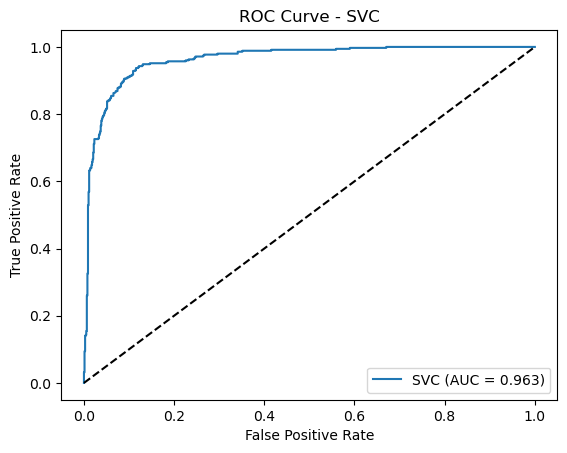

Selected main value model: RandomForest (CV ROC AUC = 0.993, test ROC AUC = 0.991)


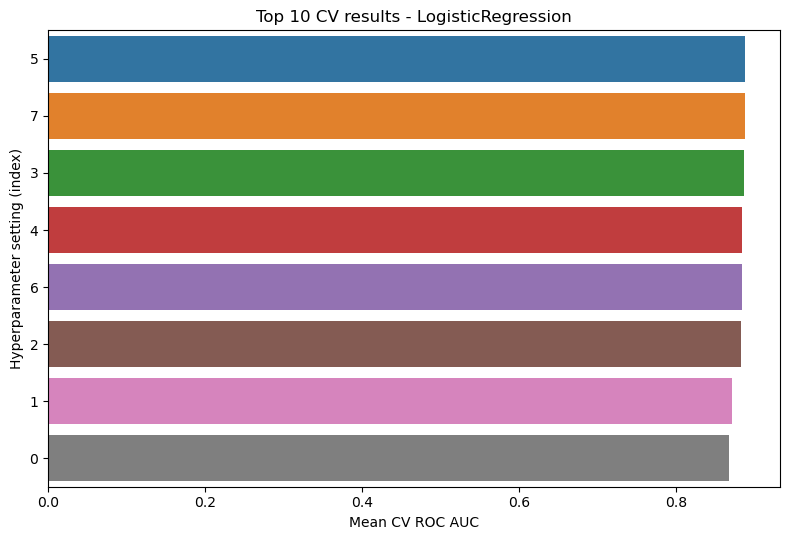


Top 10 hyperparameter settings for LogisticRegression:


,mean_test_score,std_test_score,params
5,0.887689,0.006006,"{'clf__C': 1, 'clf__class_weight': 'balanced'}"
7,0.887630,0.006044,"{'clf__C': 10, 'clf__class_weight': 'balanced'}"
3,0.886296,0.006034,"{'clf__C': 0.1, 'clf__class_weight': 'balanced'}"
4,0.884133,0.006001,"{'clf__C': 1, 'clf__class_weight': None}"
6,0.884132,0.006052,"{'clf__C': 10, 'clf__class_weight': None}"
2,0.882902,0.006079,"{'clf__C': 0.1, 'clf__class_weight': None}"
1,0.870345,0.006649,"{'clf__C': 0.01, 'clf__class_weight': 'balanced'}"
0,0.867212,0.007212,"{'clf__C': 0.01, 'clf__class_weight': None}"


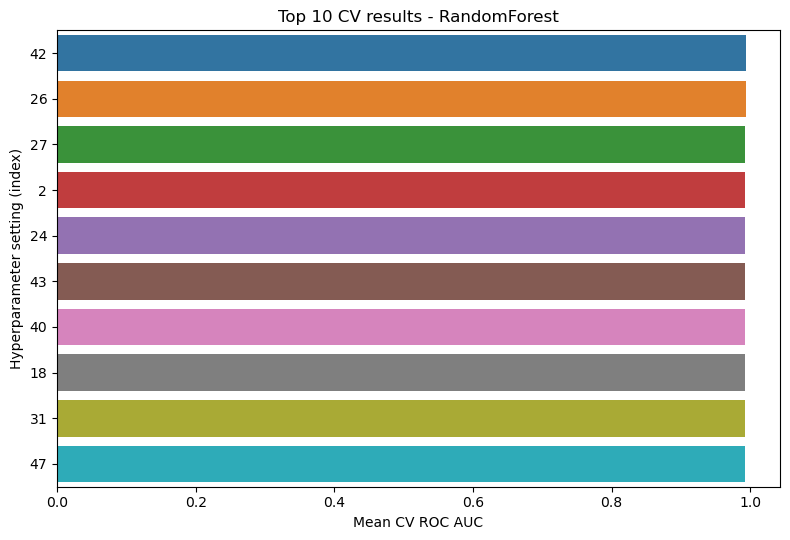


Top 10 hyperparameter settings for RandomForest:


,mean_test_score,std_test_score,params
42,0.993143,0.001832,"{'clf__class_weight': 'balanced', 'clf__max_de..."
26,0.993126,0.001877,"{'clf__class_weight': 'balanced', 'clf__max_de..."
27,0.993024,0.001834,"{'clf__class_weight': 'balanced', 'clf__max_de..."
2,0.993015,0.001934,"{'clf__class_weight': None, 'clf__max_depth': ..."
24,0.993014,0.001822,"{'clf__class_weight': 'balanced', 'clf__max_de..."
43,0.993003,0.001822,"{'clf__class_weight': 'balanced', 'clf__max_de..."
40,0.992998,0.001801,"{'clf__class_weight': 'balanced', 'clf__max_de..."
18,0.992978,0.001879,"{'clf__class_weight': None, 'clf__max_depth': ..."
31,0.992962,0.001768,"{'clf__class_weight': 'balanced', 'clf__max_de..."
47,0.992948,0.001732,"{'clf__class_weight': 'balanced', 'clf__max_de..."


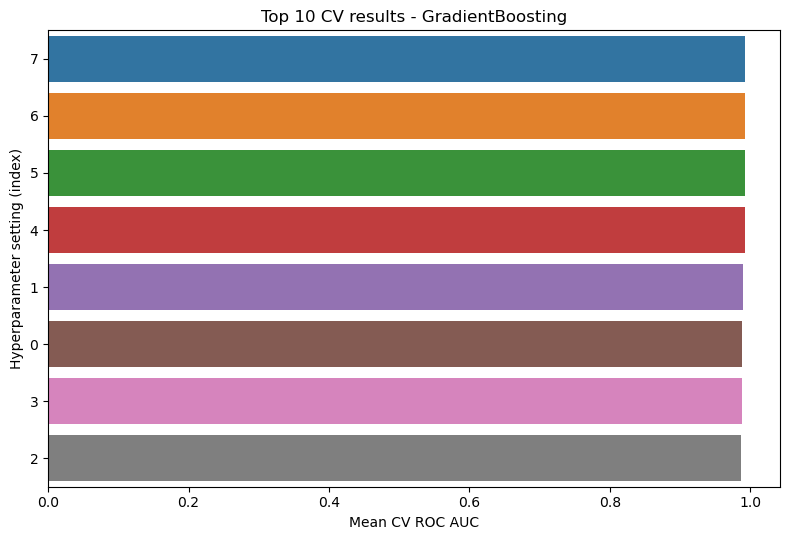


Top 10 hyperparameter settings for GradientBoosting:


,mean_test_score,std_test_score,params
7,0.992643,0.002621,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
6,0.991889,0.003891,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
5,0.991820,0.002896,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
4,0.991818,0.003164,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
1,0.990273,0.003401,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."
0,0.988460,0.003420,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."
3,0.988237,0.007497,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."
2,0.987126,0.007279,"{'clf__learning_rate': 0.01, 'clf__max_depth':..."


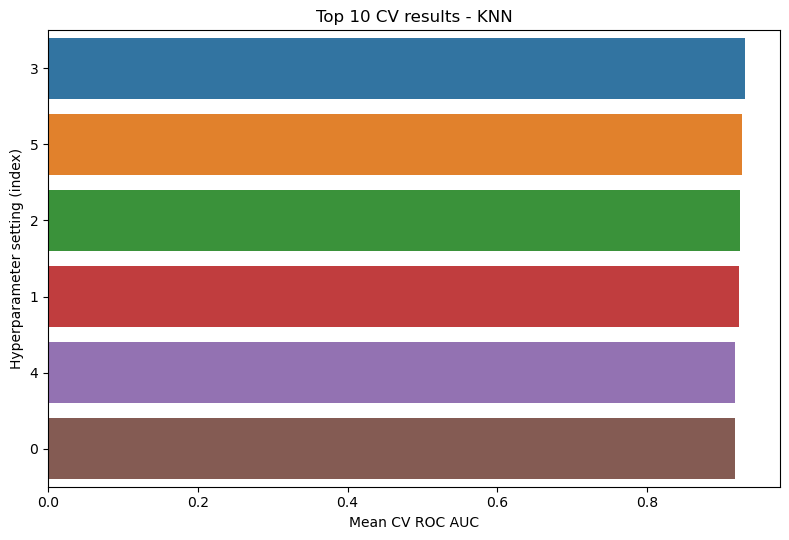


Top 10 hyperparameter settings for KNN:


,mean_test_score,std_test_score,params
3,0.931082,0.008541,"{'clf__n_neighbors': 15, 'clf__weights': 'dist..."
5,0.926813,0.010279,"{'clf__n_neighbors': 25, 'clf__weights': 'dist..."
2,0.924619,0.008775,"{'clf__n_neighbors': 15, 'clf__weights': 'unif..."
1,0.922240,0.009598,"{'clf__n_neighbors': 5, 'clf__weights': 'dista..."
4,0.917801,0.010457,"{'clf__n_neighbors': 25, 'clf__weights': 'unif..."
0,0.917296,0.009579,"{'clf__n_neighbors': 5, 'clf__weights': 'unifo..."


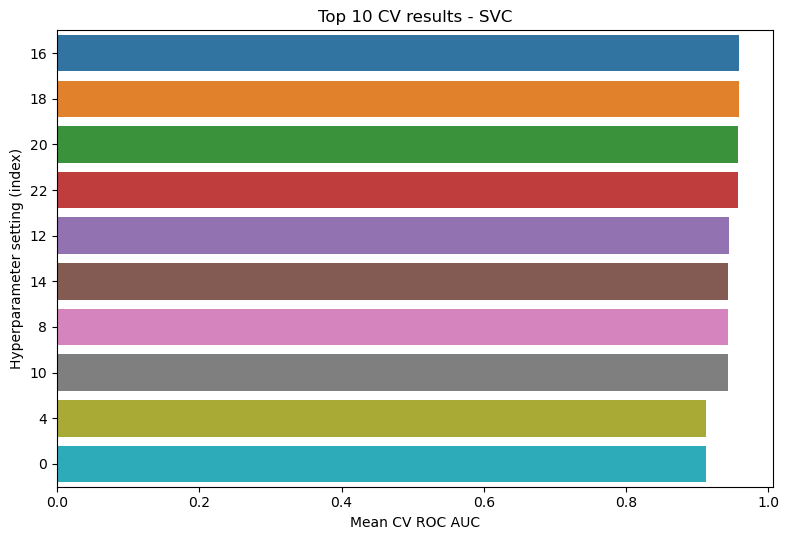


Top 10 hyperparameter settings for SVC:


,mean_test_score,std_test_score,params
16,0.958426,0.002757,"{'clf__C': 10, 'clf__class_weight': None, 'clf..."
18,0.958136,0.002707,"{'clf__C': 10, 'clf__class_weight': None, 'clf..."
20,0.957455,0.003821,"{'clf__C': 10, 'clf__class_weight': 'balanced'..."
22,0.957389,0.004019,"{'clf__C': 10, 'clf__class_weight': 'balanced'..."
12,0.944328,0.004740,"{'clf__C': 1, 'clf__class_weight': 'balanced',..."
14,0.943738,0.004811,"{'clf__C': 1, 'clf__class_weight': 'balanced',..."
8,0.943558,0.004786,"{'clf__C': 1, 'clf__class_weight': None, 'clf_..."
10,0.943285,0.004563,"{'clf__C': 1, 'clf__class_weight': None, 'clf_..."
4,0.912232,0.006247,"{'clf__C': 0.1, 'clf__class_weight': 'balanced..."
0,0.911857,0.005216,"{'clf__C': 0.1, 'clf__class_weight': None, 'cl..."


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


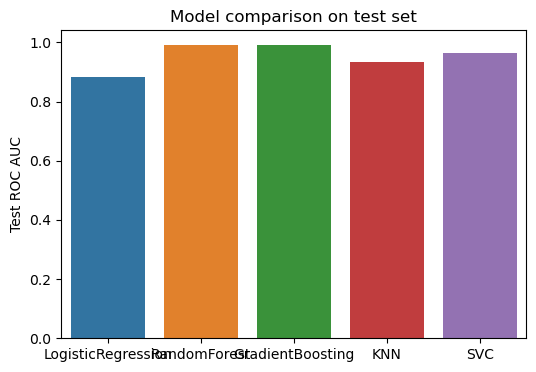

,INSTNM,CITY,STABBR,SECTOR,COSTT4_A,ENG_RATIO,ENG_PROG_COUNT,p_value_model,USER_SCORE
5015,University of Florida-Online,Gainesville,FL,Public,17036.0,0.000000,17.0,0.863653,0.744080
635,Seminole State College of Florida,Sanford,FL,Public,9152.0,0.081092,9.0,0.998991,0.742984
586,Hillsborough Community College,Tampa,FL,Public,10168.0,0.014101,8.0,0.992431,0.711617
4788,Tulsa Welding School-Jacksonville,Jacksonville,FL,For-profit,24517.0,0.347200,2.0,0.963861,0.708475
653,Valencia College,Orlando,FL,Public,16577.0,0.022798,8.0,0.946531,0.679672
640,University of South Florida,Tampa,FL,Public,22301.0,0.056706,12.0,0.913289,0.663482
631,St Petersburg College,St. Petersburg,FL,Public,10634.0,0.011003,6.0,0.963932,0.662808
614,University of North Florida,Jacksonville,FL,Public,20229.0,0.060906,4.0,0.932290,0.659186
579,University of Florida,Gainesville,FL,Public,21719.0,0.138414,17.0,0.322690,0.650490
552,University of Central Florida,Orlando,FL,Public,22819.0,0.083300,12.0,0.811673,0.649208


In [19]:
# Only keep features that actually exist
feature_cols = [c for c in (base_features + course_features) if c in df.columns]
print("Using features:", feature_cols)

# Drop rows with missing label
df_model = df.dropna(subset=["VALUE_LABEL"])

X = df_model[feature_cols]
y = df_model["VALUE_LABEL"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# -------------------------------------------------------------------
# 5. Location helper functions
# -------------------------------------------------------------------

def haversine_distance(lat1, lon1, lat2, lon2):
    """Great-circle distance between (lat1,lon1) and arrays (lat2,lon2) in km."""
    R = 6371.0  # Earth radius in km
    lat1_r = np.radians(lat1)
    lon1_r = np.radians(lon1)
    lat2_r = np.radians(lat2)
    lon2_r = np.radians(lon2)

    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r

    a = np.sin(dlat/2.0)**2 + np.cos(lat1_r)*np.cos(lat2_r)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def annotate_distance(df_in, user_lat, user_lon):
    """
    Add a DISTANCE_KM column to a copy of df_in, using user's home lat/lon.
    Requires LATITUDE, LONGITUDE columns.
    """
    df_loc = df_in.copy()
    if not {"LATITUDE", "LONGITUDE"} <= set(df_loc.columns):
        print("LATITUDE/LONGITUDE columns missing; returning dataframe unchanged.")
        return df_loc

    distances = haversine_distance(
        user_lat, user_lon,
        df_loc["LATITUDE"].values,
        df_loc["LONGITUDE"].values
    )
    df_loc["DISTANCE_KM"] = distances
    return df_loc

def filter_by_radius(df_in, user_lat, user_lon, radius_km):
    """Return only colleges within radius_km of the user."""
    df_with_dist = annotate_distance(df_in, user_lat, user_lon)
    if "DISTANCE_KM" not in df_with_dist.columns:
        return df_with_dist
    return df_with_dist[df_with_dist["DISTANCE_KM"] <= radius_km]

# -------------------------------------------------------------------
# 6. Multi-model classification with GridSearchCV
# -------------------------------------------------------------------

classifiers = {}

# 1. Logistic 



log_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

log_reg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}
# log_reg_param_grid = [

#     # L2 penalty
#     {
#         "clf__penalty": ["l2"],
#         "clf__solver": ["lbfgs", "saga"],
#         "clf__C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
#     },

#     # L1 penalty
#     {
#         "clf__penalty": ["l1"],
#         "clf__solver": ["liblinear", "saga"],
#         "clf__C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
#     },

#     # ElasticNet (requires L1_ratio + saga)
#     {
#         "clf__penalty": ["elasticnet"],
#         "clf__solver": ["saga"],
#         "clf__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0],
#         "clf__C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
#     }
# ]

classifiers["LogisticRegression"] = (log_reg_pipe, log_reg_param_grid)

# 2. Random Forest
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__class_weight": [None, "balanced"]
}
# rf_param_grid = {
#     "clf__n_estimators": [200, 400, 600],                 
#     "clf__max_depth": [None, 10, 20, 30],                
#     "clf__min_samples_split": [2, 5, 10],                
#     "clf__min_samples_leaf": [1, 2, 4],                  
#     "clf__max_features": ["sqrt", "log2"],               
#     "clf__class_weight": [None, "balanced"]
# }
classifiers["RandomForest"] = (rf_pipe, rf_param_grid)

# 3. Gradient Boosting
gb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5]
}
# gb_param_grid = {
#     "clf__n_estimators": [100, 200, 300],
#     "clf__learning_rate": [0.01, 0.05, 0.1],
#     "clf__max_depth": [3, 5, 7],
#     "clf__subsample": [1.0, 0.8],
#     "clf__max_features": ["sqrt", "log2"]
# }

classifiers["GradientBoosting"] = (gb_pipe, gb_param_grid)

# 4. KNN
knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

knn_param_grid = {
    "clf__n_neighbors": [5, 15, 25],
    "clf__weights": ["uniform", "distance"]
}
# knn_param_grid = {
#     "clf__n_neighbors": [3, 5, 11, 15, 21, 25],
#     "clf__weights": ["uniform", "distance"],
#     "clf__metric": ["euclidean", "manhattan"]
# }

classifiers["KNN"] = (knn_pipe, knn_param_grid)

# 5. Support Vector Classifier
svc_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])

svc_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf", "linear"],
    "clf__class_weight": [None, "balanced"]
}
# svc_param_grid = {
#     "clf__C": [0.1, 1, 5, 10, 20],
#     "clf__gamma": ["scale", "auto", 0.01, 0.001],
#     "clf__kernel": ["rbf", "linear", "poly"],
#     "clf__degree": [2, 3],
#     "clf__class_weight": [None, "balanced"]
# }

classifiers["SVC"] = (svc_pipe, svc_param_grid)



best_classifiers = {}
cv_results_dict = {}
test_metrics = {}
cv_best_scores = {}

for name, (pipe, param_grid) in classifiers.items():
    print("="*80)
    print(f"Running {name}")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV ROC AUC: {grid.best_score_:.3f}")

    cv_best_scores[name] = grid.best_score_

    best_model = grid.best_estimator_
    best_classifiers[name] = best_model

    # Save cv results for later plots
    cv_results = pd.DataFrame(grid.cv_results_)
    cv_results_dict[name] = cv_results

    # Test set evaluation
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    print("\nTest classification report:")
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print("Test ROC AUC:", auc)
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    test_metrics[name] = {"roc_auc": auc}

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

# Choose main model for ranking using CV ROC AUC (keep test set as blind check)
best_model_name = max(cv_best_scores, key=cv_best_scores.get)
value_model = best_classifiers[best_model_name]
print(
    f"Selected main value model: {best_model_name} "
    f"(CV ROC AUC = {cv_best_scores[best_model_name]:.3f}, "
    f"test ROC AUC = {test_metrics[best_model_name]['roc_auc']:.3f})"
)

# -------------------------------------------------------------------
# 7. Plot CV performance for each model (hyperparameter combos)
# -------------------------------------------------------------------

def plot_cv_performance(cv_results, model_name, top_n=15):
    """
    Plot mean CV score for the top_n hyperparameter combinations.
    Each bar corresponds to one 'params' setting in cv_results_.
    """
    df_cv = cv_results.copy()
    df_cv = df_cv.sort_values("mean_test_score", ascending=False).head(top_n)

    plt.figure(figsize=(8, 4 + top_n * 0.15))
    sns.barplot(
        data=df_cv,
        x="mean_test_score",
        y=df_cv.index.astype(str),
        orient="h"
    )
    plt.xlabel("Mean CV ROC AUC")
    plt.ylabel("Hyperparameter setting (index)")
    plt.title(f"Top {top_n} CV results - {model_name}")
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_n} hyperparameter settings for {model_name}:")
    display(df_cv[["mean_test_score", "std_test_score", "params"]])

for name, cv_res in cv_results_dict.items():
    plot_cv_performance(cv_res, name, top_n=10)

# Compare final test ROC AUC across models
plt.figure(figsize=(6, 4))
names = list(test_metrics.keys())
scores = [test_metrics[m]["roc_auc"] for m in names]
sns.barplot(x=names, y=scores)
plt.ylabel("Test ROC AUC")
plt.title("Model comparison on test set")
plt.show()

# -------------------------------------------------------------------
# 8. Ranking function with user weights (course-level + location)
# -------------------------------------------------------------------

def minmax_series(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

def rank_colleges_for_user(
    df_raw,
    feature_cols,
    value_model,
    user_weights,
    user_lat=None,
    user_lon=None,
    radius_km=None
):
    """
    user_weights example:
        {
          "value_model": 5,
          "cost": 5,
          "engineering": 4,
          "debt": 3,
          "location": 2,
          "program_count": 2,
          "prefer_public": 3,
          "prefer_private": 0
        }
    If user_lat, user_lon, radius_km are provided, will filter to those within radius.
    """
    df_scored = df_raw.copy()

    # Apply location filter if requested
    if (user_lat is not None) and (user_lon is not None) and (radius_km is not None):
        df_scored = filter_by_radius(df_scored, user_lat, user_lon, radius_km)

    # Model-based probability of being "high-value"
    X_all = df_scored[feature_cols]
    p_value = value_model.predict_proba(X_all)[:, 1]
    df_scored["p_value_model"] = p_value

    # Cost score (lower cost -> higher score)
    df_scored["cost_score"] = 1 - minmax_series(df_scored["COSTT4_A"])

    # Engineering intensity
    df_scored["eng_score"] = minmax_series(df_scored["ENG_RATIO"])

    # Debt score from course-level aggregates (lower debt -> higher score)
    debt_cols_present = [c for c in df_scored.columns if "DEBT_ALL_STGP_ANY_MDN" in c]
    if len(debt_cols_present) > 0:
        debt_raw = df_scored[debt_cols_present].mean(axis=1)
        df_scored["debt_score"] = 1 - minmax_series(debt_raw)
    else:
        df_scored["debt_score"] = 0.5

    # Program count (more engineering programs may be good)
    if "ENG_PROG_COUNT" in df_scored.columns:
        df_scored["prog_count_score"] = minmax_series(df_scored["ENG_PROG_COUNT"])
    else:
        df_scored["prog_count_score"] = 0.5

    # Location score: closer is better (if distance available)
    if "DISTANCE_KM" in df_scored.columns:
        df_scored["location_score"] = 1 - minmax_series(df_scored["DISTANCE_KM"])
    else:
        df_scored["location_score"] = 0.5

    # Sector (public / private)
    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        sector_indicator = np.where(
            df_scored["IS_PUBLIC"] == 1, 1.0,
            np.where(df_scored["IS_PRIVATE"] == 1, 0.0, 0.5)
        )
    else:
        sector_indicator = np.full(len(df_scored), 0.5)
    df_scored["sector_indicator"] = sector_indicator

    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        df_scored["SECTOR"] = np.select(
            [
                df_scored["IS_PUBLIC"] == 1,
                df_scored["IS_PRIVATE"] == 1,
                df_scored["IS_FORPROFIT"] == 1
            ],
            ["Public", "Private", "For-profit"],
            default="Other"
        )
    else:
        df_scored["SECTOR"] = "Unknown"

    # Weights
    w_value   = user_weights.get("value_model", 0)
    w_cost    = user_weights.get("cost", 0)
    w_eng     = user_weights.get("engineering", 0)
    w_debt    = user_weights.get("debt", 0)
    w_loc     = user_weights.get("location", 0)
    w_prog    = user_weights.get("program_count", 0)
    w_public  = user_weights.get("prefer_public", 0)
    w_private = user_weights.get("prefer_private", 0)

    # Sector preference component
    sector_component = (
        w_public  * df_scored["sector_indicator"] +
        w_private * (1 - df_scored["sector_indicator"])
    )

    total_w = (
        w_value + w_cost + w_eng + w_debt + w_loc + w_prog +
        w_public + w_private
    )
    if total_w == 0:
        raise ValueError("All user weights are zero!")

    df_scored["USER_SCORE"] = (
        w_value * df_scored["p_value_model"] +
        w_cost  * df_scored["cost_score"] +
        w_eng   * df_scored["eng_score"] +
        w_debt  * df_scored["debt_score"] +
        w_loc   * df_scored["location_score"] +
        w_prog  * df_scored["prog_count_score"] +
        sector_component
    ) / total_w

    cols_to_show = [
        "INSTNM", "CITY", "STABBR", "SECTOR",
        "COSTT4_A", "ENG_RATIO", "ENG_PROG_COUNT",
        "p_value_model", "USER_SCORE"
    ]
    cols_to_show = [c for c in cols_to_show if c in df_scored.columns]

    ranked = df_scored.sort_values("USER_SCORE", ascending=False)
    return ranked[cols_to_show]

# -------------------------------------------------------------------
# 9. Example usage for ranking
# -------------------------------------------------------------------

example_weights = {
    "value_model": 5,
    "cost": 5,
    "engineering": 4,
    "debt": 3,
    "location": 2,
    "program_count": 2,
    "prefer_public": 3,
    "prefer_private": 0
}

# Example user location (Gainesville, FL-ish) and radius
user_lat_example = 29.6516
user_lon_example = -82.3248
radius_km_example = 300

ranked_colleges = rank_colleges_for_user(
    df_raw=df,
    feature_cols=feature_cols,
    value_model=value_model,
    user_weights=example_weights,
    user_lat=user_lat_example,
    user_lon=user_lon_example,
    radius_km=radius_km_example
)

ranked_colleges.head(20)




#  Regression models on QUALITY_SCORE
Using the same feature set (institution + course aggregates) to predict QUALITY_SCORE with a few regressors.


Running RandomForestRegressor
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best params for RandomForestRegressor:
{'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV R²: 0.946

Test R²: 0.9437468204589539
Test RMSE: 0.011942390210400796


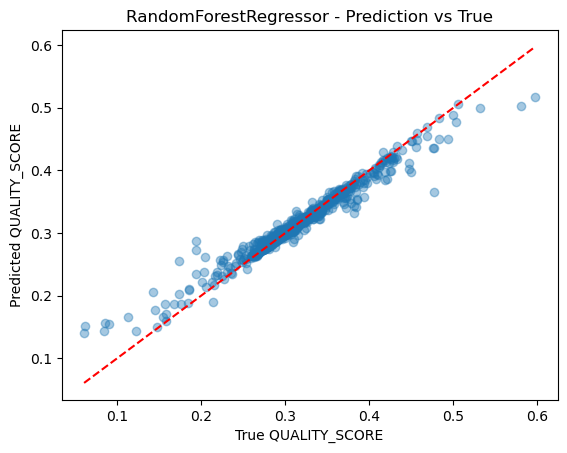

Running GradientBoostingRegressor
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best params for GradientBoostingRegressor:
{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__max_features': 'sqrt', 'clf__n_estimators': 300, 'clf__subsample': 1.0}
Best CV R²: 0.991

Test R²: 0.9899613979633011
Test RMSE: 0.005044920640341219


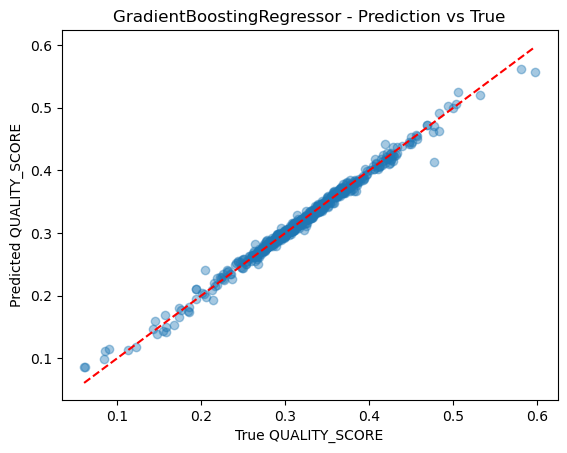

Running ElasticNet
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best params for ElasticNet:
{'clf__alpha': 0.01, 'clf__l1_ratio': 0.1}
Best CV R²: 0.999

Test R²: 0.9988934037929473
Test RMSE: 0.0016749903476759676


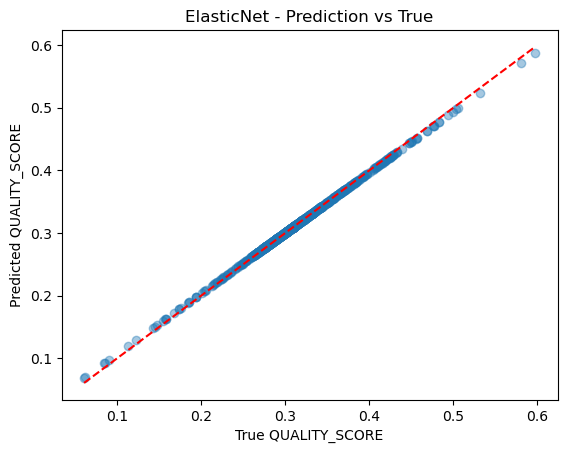

Running SVR
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best params for SVR:
{'clf__C': 0.1, 'clf__epsilon': 0.01, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Best CV R²: 0.994

Test R²: 0.994956260849613
Test RMSE: 0.00357597133625986


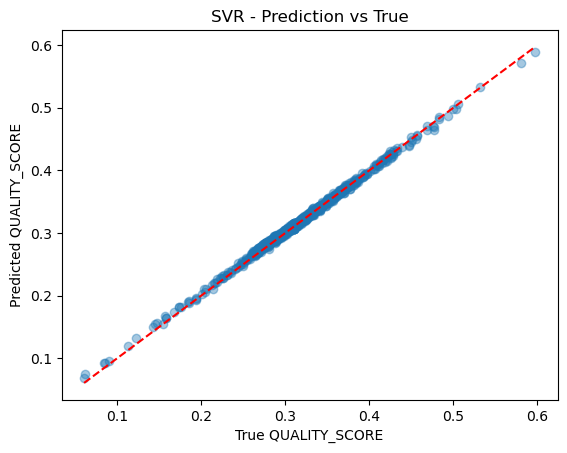

Selected main regression model: ElasticNet (CV R² = 0.999, test R² = 0.999, test RMSE = 0.002)


In [20]:
# -------------------------------------------------------------------
# 10. Regression models (predict QUALITY_SCORE)
# -------------------------------------------------------------------
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Prepare regression data
reg_df = df.dropna(subset=["QUALITY_SCORE"])
X_reg = reg_df[feature_cols]
y_reg = reg_df["QUALITY_SCORE"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=42
)

regressors = {}

# 1) Random Forest Regressor
rf_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestRegressor(random_state=42))
])

rf_reg_param_grid = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"]
}

regressors["RandomForestRegressor"] = (rf_reg_pipe, rf_reg_param_grid)

# 2) Gradient Boosting Regressor
gb_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingRegressor(random_state=42))
])

gb_reg_param_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [3, 5, 7],
    "clf__subsample": [1.0, 0.8],
    "clf__max_features": ["sqrt", "log2"]
}

regressors["GradientBoostingRegressor"] = (gb_reg_pipe, gb_reg_param_grid)

# 3) ElasticNet (linear with L1+L2)
en_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", ElasticNet(max_iter=5000))
])

en_param_grid = {
    "clf__alpha": [0.01, 0.1, 1.0, 10.0],
    "clf__l1_ratio": [0.1, 0.5, 0.9]
}

regressors["ElasticNet"] = (en_pipe, en_param_grid)

# 4) Support Vector Regressor
svr_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVR())
])

svr_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__epsilon": [0.01, 0.1, 0.2],
    "clf__kernel": ["rbf", "linear"]
}

regressors["SVR"] = (svr_pipe, svr_param_grid)

# -------------------------------------------------------------------
# Run regressors and report performance
# -------------------------------------------------------------------
best_regressors = {}
reg_cv_best_scores = {}
reg_test_metrics = {}

for name, (pipe, param_grid) in regressors.items():
    print("="*80)
    print(f"Running {name}")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="r2",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(Xr_train, yr_train)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV R²: {grid.best_score_:.3f}")

    reg_cv_best_scores[name] = grid.best_score_

    best_model = grid.best_estimator_
    best_regressors[name] = best_model

    yr_pred = best_model.predict(Xr_test)
    r2 = r2_score(yr_test, yr_pred)
    rmse = mean_squared_error(yr_test, yr_pred, squared=False)

    print("\nTest R²:", r2)
    print("Test RMSE:", rmse)

    reg_test_metrics[name] = {"r2": r2, "rmse": rmse}

    plt.figure()
    plt.scatter(yr_test, yr_pred, alpha=0.4)
    plt.xlabel("True QUALITY_SCORE")
    plt.ylabel("Predicted QUALITY_SCORE")
    plt.title(f"{name} - Prediction vs True")
    plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], "r--")
    plt.show()

# Pick main regression model using CV R²
best_reg_name = max(reg_cv_best_scores, key=reg_cv_best_scores.get)
quality_model = best_regressors[best_reg_name]
print(
    f"Selected main regression model: {best_reg_name} "
    f"(CV R² = {reg_cv_best_scores[best_reg_name]:.3f}, "
    f"test R² = {reg_test_metrics[best_reg_name]['r2']:.3f}, "
    f"test RMSE = {reg_test_metrics[best_reg_name]['rmse']:.3f})"
)


# Conclusion: Model heavily overfits. It is trivial becasue in the regression model our target is QUALITY_SCORE, which is directly calculated from the some of the same institute level features (refer the preprocessing files). So, we need to drop the features to get no leakage while training.

df["QUALITY_SCORE"] = (
    0.4 * df["GRAD_RATE"] +
    0.3 * df["RET_FT4"] +
    0.3 * (df["MD_EARN_WNE_P10"] / (df["MD_EARN_WNE_P10"].max() + 1))
)


So dropping the features that goes to make Quality score

Regression without QUALITY_SCORE ingredients
Remove leakage by excluding GRAD_RATE, RET_FT4, MD_EARN_WNE_P10 (used to build QUALITY_SCORE) from the regression feature set, then retrain.


In [22]:
# -------------------------------------------------------------------
# 12. Regression re-run excluding QUALITY_SCORE ingredients
# -------------------------------------------------------------------
leak_cols = {"GRAD_RATE", "RET_FT4", "MD_EARN_WNE_P10", "QUALITY_SCORE"}
quality_reg_features = [c for c in feature_cols if c not in leak_cols]
print("Regression features (no leakage):", quality_reg_features)

reg_df_noleak = df.dropna(subset=["QUALITY_SCORE"])
X_reg_noleak = reg_df_noleak[quality_reg_features]
y_reg_noleak = reg_df_noleak["QUALITY_SCORE"]

Xr_train_nl, Xr_test_nl, yr_train_nl, yr_test_nl = train_test_split(
    X_reg_noleak, y_reg_noleak,
    test_size=0.2,
    random_state=42
)

best_regressors_nl = {}
reg_cv_best_scores_nl = {}
reg_test_metrics_nl = {}

regressor_defs = regressors  # reuse pipelines and grids defined earlier

for name, (pipe, param_grid) in regressor_defs.items():
    print("="*80)
    print(f"Running {name} (no-leak features)")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="r2",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(Xr_train_nl, yr_train_nl)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV R²: {grid.best_score_:.3f}")

    reg_cv_best_scores_nl[name] = grid.best_score_

    best_model = grid.best_estimator_
    best_regressors_nl[name] = best_model

    yr_pred = best_model.predict(Xr_test_nl)
    r2 = r2_score(yr_test_nl, yr_pred)
    rmse = mean_squared_error(yr_test_nl, yr_pred, squared=False)

    print("\nTest R²:", r2)
    print("Test RMSE:", rmse)

    reg_test_metrics_nl[name] = {"r2": r2, "rmse": rmse}

# Pick main regression model using CV R² (no-leak)
best_reg_name_nl = max(reg_cv_best_scores_nl, key=reg_cv_best_scores_nl.get)
quality_model_noleak = best_regressors_nl[best_reg_name_nl]
print(
    f"Selected no-leak regression model: {best_reg_name_nl} "
    f"(CV R² = {reg_cv_best_scores_nl[best_reg_name_nl]:.3f}, "
    f"test R² = {reg_test_metrics_nl[best_reg_name_nl]['r2']:.3f}, "
    f"test RMSE = {reg_test_metrics_nl[best_reg_name_nl]['rmse']:.3f})"
)


Regression features (no leakage): ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'ADM_RATE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT', 'ENG_PROG_COUNT', 'ENG_CRED_LEVELS', 'DEBT_ALL_STGP_ANY_MDN_mean', 'DEBT_ALL_STGP_ANY_MDN_min', 'DEBT_ALL_STGP_ANY_MDN_max', 'DEBT_ALL_PP_ANY_MDN_mean', 'DEBT_ALL_PP_ANY_MDN_min', 'DEBT_ALL_PP_ANY_MDN_max']
Running RandomForestRegressor (no-leak features)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best params for RandomForestRegressor:
{'clf__max_depth': 30, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best CV R²: 0.522

Test R²: 0.4773993566840248
Test RMSE: 0.03640010949576696
Running GradientBoostingRegressor (no-leak features)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best params for GradientBoostingRegressor:
{'clf__le

# Optional: College prediction with user weights
Quick block to plug in custom weights and (optionally) a location radius, then rank colleges using the classification value model.


In [25]:
# -------------------------------------------------------------------
# 11. College prediction with user-defined weights
# -------------------------------------------------------------------
# Adjust these weights (0–5) to reflect user preferences
user_weights_custom = {
    "value_model": 5,      # trust in the ML value classifier
    "cost": 4,             # lower tuition preference
    "engineering": 4,      # engineering intensity
    "debt": 3,             # lower program-level debt
    "location": 2,         # closer is better (uses distance if available)
    "program_count": 2,    # more engineering programs
    "prefer_public": 1,    # favor public schools
    "prefer_private": 0    # favor private schools (set >0 instead of public if desired)
}

# Optional: user location and radius for filtering (set to None to disable)
user_lat = 37.7749   # e.g., San Francisco latitude
user_lon = -122.4194 # e.g., San Francisco longitude
radius_km = 300      # set to None if you don't want distance filtering

top_n = 20  # how many rows to display

ranked_for_user = rank_colleges_for_user(
    df_raw=df,
    feature_cols=feature_cols,
    value_model=value_model,
    user_weights=user_weights_custom,
    user_lat=user_lat,
    user_lon=user_lon,
    radius_km=radius_km,
)

display(ranked_for_user.head(top_n))


,INSTNM,CITY,STABBR,SECTOR,COSTT4_A,ENG_RATIO,ENG_PROG_COUNT,p_value_model,USER_SCORE
195,California State University-Fresno,Fresno,CA,Public,18650.0,0.052616,8.0,0.970835,0.661492
393,San Jose State University,San Jose,CA,Public,25695.0,0.141614,14.0,0.330106,0.642823
215,California State University Maritime Academy,Vallejo,CA,Public,27138.0,0.278100,4.0,0.174959,0.622483
201,California State University-Sacramento,Sacramento,CA,Public,22714.0,0.074393,7.0,0.577039,0.597058
4247,Asher College,Sacramento,CA,For-profit,24517.0,0.000000,1.0,0.926649,0.593685
202,University of California-Berkeley,Berkeley,CA,Public,42708.0,0.122412,15.0,0.055054,0.571216
386,San Francisco State University,San Francisco,CA,Public,25258.0,0.034097,7.0,0.376637,0.552300
4177,University of California-Merced,Merced,CA,Public,37098.0,0.244976,6.0,0.132709,0.547899
193,California State University-Chico,Chico,CA,Public,25590.0,0.096319,9.0,0.371927,0.539408
1719,University of Nevada-Reno,Reno,NV,Public,24702.0,0.094209,13.0,0.264891,0.515709


# Conclusion: 
# Removing GRAD_RATE, RET_FT4, and MD_EARN_WNE_P10 eliminates target leakage/overfitting in the regression.
# The leakage-free model can score new schools that lack outcomes data by using other available features to estimate QUALITY_SCORE.
# The QUALITY_SCORE formula weights can be tuned if you want a different emphasis, and the regression still gives students a practical quality signal.

# Training on different window of Hyperparameters
Broader (but still modest) hyperparameter ranges for the leakage-free regression rerun.


In [24]:
# -------------------------------------------------------------------
# Wider-yet-modest hyperparameter sweep (no-leak regression)
# -------------------------------------------------------------------
leak_cols = {"GRAD_RATE", "RET_FT4", "MD_EARN_WNE_P10", "QUALITY_SCORE"}
quality_reg_features = [c for c in feature_cols if c not in leak_cols]
print("Regression features (no leakage):", quality_reg_features)

reg_df_noleak = df.dropna(subset=["QUALITY_SCORE"])
X_reg_noleak = reg_df_noleak[quality_reg_features]
y_reg_noleak = reg_df_noleak["QUALITY_SCORE"]

Xr_train_nl, Xr_test_nl, yr_train_nl, yr_test_nl = train_test_split(
    X_reg_noleak, y_reg_noleak,
    test_size=0.2,
    random_state=42
)

# Expanded-but-reasonable grids
rf_reg_param_grid_wide = {
    "clf__n_estimators": [200, 400, 600, 800],
    "clf__max_depth": [None, 15, 25, 35],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"]
}

gb_reg_param_grid_wide = {
    "clf__n_estimators": [200, 300, 400],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__max_depth": [5, 7],
    "clf__subsample": [1.0, 0.8],
    "clf__max_features": ["sqrt", "log2"]
}

en_param_grid_wide = {
    "clf__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
    "clf__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]
}

svr_param_grid_wide = {
    "clf__C": [0.1, 0.5, 1, 5],
    "clf__gamma": ["scale", "auto", 0.01],
    "clf__epsilon": [0.005, 0.01, 0.05, 0.1],
    "clf__kernel": ["rbf", "linear"]
}

regressors_wide = {
    "RandomForestRegressor": (rf_reg_pipe, rf_reg_param_grid_wide),
    "GradientBoostingRegressor": (gb_reg_pipe, gb_reg_param_grid_wide),
    "ElasticNet": (en_pipe, en_param_grid_wide),
    "SVR": (svr_pipe, svr_param_grid_wide),
}

best_regressors_wide = {}
reg_cv_best_scores_wide = {}
reg_test_metrics_wide = {}

for name, (pipe, param_grid) in regressors_wide.items():
    print("="*80)
    print(f"Running {name} (wider grid, no-leak)")
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="r2",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(Xr_train_nl, yr_train_nl)

    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV R²: {grid.best_score_:.3f}")

    reg_cv_best_scores_wide[name] = grid.best_score_

    best_model = grid.best_estimator_
    best_regressors_wide[name] = best_model

    yr_pred = best_model.predict(Xr_test_nl)
    r2 = r2_score(yr_test_nl, yr_pred)
    rmse = mean_squared_error(yr_test_nl, yr_pred, squared=False)

    print("\nTest R²:", r2)
    print("Test RMSE:", rmse)

    reg_test_metrics_wide[name] = {"r2": r2, "rmse": rmse}

best_reg_name_wide = max(reg_cv_best_scores_wide, key=reg_cv_best_scores_wide.get)
quality_model_noleak_wide = best_regressors_wide[best_reg_name_wide]
print(
    f"Selected wider-grid regression model: {best_reg_name_wide} "
    f"(CV R² = {reg_cv_best_scores_wide[best_reg_name_wide]:.3f}, "
    f"test R² = {reg_test_metrics_wide[best_reg_name_wide]['r2']:.3f}, "
    f"test RMSE = {reg_test_metrics_wide[best_reg_name_wide]['rmse']:.3f})"
)


Regression features (no leakage): ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'ADM_RATE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT', 'ENG_PROG_COUNT', 'ENG_CRED_LEVELS', 'DEBT_ALL_STGP_ANY_MDN_mean', 'DEBT_ALL_STGP_ANY_MDN_min', 'DEBT_ALL_STGP_ANY_MDN_max', 'DEBT_ALL_PP_ANY_MDN_mean', 'DEBT_ALL_PP_ANY_MDN_min', 'DEBT_ALL_PP_ANY_MDN_max']
Running RandomForestRegressor (wider grid, no-leak)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best params for RandomForestRegressor:
{'clf__max_depth': 25, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 600}
Best CV R²: 0.520

Test R²: 0.4765933316210511
Test RMSE: 0.03642816925501722
Running GradientBoostingRegressor (wider grid, no-leak)
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best params for GradientBoostingRegressor:
{'cl

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.749e+00, tolerance: 9.010e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+00, tolerance: 9.107e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin


Best params for ElasticNet:
{'clf__alpha': 0.01, 'clf__l1_ratio': 0.0}
Best CV R²: 0.382

Test R²: 0.39531426250893464
Test RMSE: 0.0391545811603254
Running SVR (wider grid, no-leak)
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best params for SVR:
{'clf__C': 0.1, 'clf__epsilon': 0.01, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV R²: 0.451

Test R²: 0.42623982649269754
Test RMSE: 0.03814019592428188
Selected wider-grid regression model: RandomForestRegressor (CV R² = 0.520, test R² = 0.477, test RMSE = 0.036)


# Now this model is more useful to a new school to determine its quality. A regression model to predict MD_EARN_WNE_P10 directly from the same no-leak feature set to give students an earnings-focused signal.

# We made the target as the earning features only in the notebooks - "ML_institute_only_earnings_slider.ipynb"
# "ML_institute_only_earnings-prediction.ipynb"